<a href="https://colab.research.google.com/github/stepan-zykov/selfedu/blob/main/33GenerativeAdversarialNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=_zyh1mzXDqQ&list=PLA0M1Bcd0w8yv0XGiF1wjerjSZVSrYbjh&index=32

In [60]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

In [61]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [62]:
x_train.shape

(60000, 28, 28)

In [63]:
x_train = x_train[y_train == 7]
y_train = y_train[y_train == 7]

In [64]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

In [65]:
BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE

In [66]:
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]

In [67]:
print(x_train.shape, y_train.shape)

(6200, 28, 28) (6200,)


In [68]:
x_train  = x_train / 255
x_test = x_test / 255

In [69]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [70]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [71]:
hidden_dim = 2

In [72]:
def dropout_and_batch():
    return Dropout(0.3)(BatchNormalization())

In [73]:
# генератор
generator = tf.keras.Sequential([
    Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim,)),
    BatchNormalization(),
    Reshape((7, 7, 256)),
    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')])

In [74]:
# дискриминатор
discriminator = tf.keras.Sequential()

discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))

In [75]:
# потери
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [76]:
def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [77]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [78]:
# обучение
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss


In [79]:
def train(dataset, epochs):
    history = []
    MAX_PRINT_LABEL = 10
    th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)

    for epoch in range(1, epochs + 1):
        print(f'{epoch}/{epochs}: ', end='')

        start = time.time()
        n = 0

        gen_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            if (n % th == 0):
              print('=', end='')
            n += 1

        history += [gen_loss_epoch / n]
        print(': ' + str(history[-1]))
        print('Время эпохи {} составляет {} секунд'.format(epoch, time.time() - start))

    return history

1/20: ===========: tf.Tensor(1.4366766, shape=(), dtype=float32)
Время эпохи 1 составляет 4.9447221755981445 секунд
2/20: ===========: tf.Tensor(2.4835231, shape=(), dtype=float32)
Время эпохи 2 составляет 1.121995210647583 секунд
3/20: ===========: tf.Tensor(3.1988509, shape=(), dtype=float32)
Время эпохи 3 составляет 1.1049211025238037 секунд
4/20: ===========: tf.Tensor(3.3224537, shape=(), dtype=float32)
Время эпохи 4 составляет 1.1029534339904785 секунд
5/20: ===========: tf.Tensor(3.0988467, shape=(), dtype=float32)
Время эпохи 5 составляет 1.107611894607544 секунд
6/20: ===========: tf.Tensor(2.5401547, shape=(), dtype=float32)
Время эпохи 6 составляет 1.108731746673584 секунд
7/20: ===========: tf.Tensor(1.8659977, shape=(), dtype=float32)
Время эпохи 7 составляет 1.1053001880645752 секунд
8/20: ===========: tf.Tensor(1.7081538, shape=(), dtype=float32)
Время эпохи 8 составляет 1.109194040298462 секунд
9/20: ===========: tf.Tensor(1.5449249, shape=(), dtype=float32)
Время эпохи

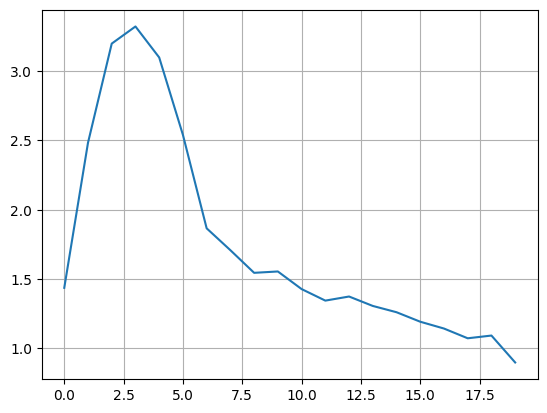

In [80]:
# запуск процесса обучения
EPOCHS = 20
history = train(train_dataset, EPOCHS)

plt.plot(history)
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 18ms/step


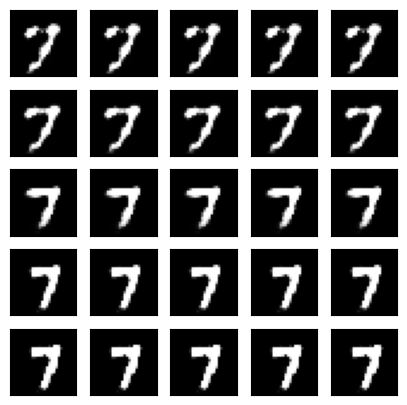

In [81]:
# отображение результатов генерации
n = 2
total = 2 * n + 1

plt.figure(figsize=(total, total))
num = 1
for i in range(-n, n+1):
    for j in range(-n, n + 1):
        ax = plt.subplot(total, total, num)
        num += 1
        img = generator.predict(np.expand_dims([0.5*i/n, 0.5*i/n], axis=0))
        plt.imshow(img[0,:,:,0], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()
